In [ ]:
import numpy as np
import time
import random
import collections

import matplotlib.pyplot as plt
import pickle

# **Using Q-Learning**

In [ ]:
episodes=2000
epsilon = 0.2 # Exploration rate
gamma = 0.8 # Discount factor
LEARNING_RATE = 0.01 # Learning rate
start_q_table = None
q_table=dict()
count = 0
episode_rewards = []
SHOW_EVERY = 200


class Environment(object):
    """A grid world with pellets to collect and an enemy to avoid."""

    def __init__(self, size, pellet_count):
        """Environments have fixed size and pellet counts."""
        #size of the environment
        self.size = size
        self.directions = [(0, 1), (1, 0), (0, -1), (-1, 0)] # left, down, right, up
        #pellate count
        self.density = pellet_count
        self.pacman = tuple()
        self.ghost = tuple()
        self.pellets = list()
        self.next_reward = 0
        self.count1=0
        self.q_table = dict()

        
    def initialize(self):
        """Place pacman, pellets, and ghost at random locations."""
        
        locations = list()
        for r in range(0,self.size):
            for c in range(0,self.size):
                locations.append((r, c))
        
        random.shuffle(locations)
        self.pacman = locations.pop()

        self.new_ghost()
        # print(self.pacman)
        # print(self.ghost)

        locations.remove(self.ghost)



        #self.pellets = list()
        for count in range(self.density):
            self.pellets.append(locations.pop())
        
            
        
        self.next_reward = 0
    
    def new_ghost(self):
        """Place a ghost at one end of pacman's row or column."""
        (r, c) = self.pacman
        #locations possible
        locations = [(r, 0), (0, c), (r, self.size-1), (self.size-1, c)]

        #randomly choosing
        choice = random.choice(range(len(locations)))
        self.ghost = locations[choice]

        if self.ghost == self.pacman:
          locations.remove(self.pacman)
          choice = random.choice(range(len(locations)))
          self.ghost = locations[choice]
          if self.ghost == self.pacman:
            locations.remove(self.pacman)
            choice = random.choice(range(len(locations)))
            self.ghost = locations[choice]


 
    
    def random_pellets(self):
      """if pellates gets finished then randomly pellates re appear"""

      locations1 = list()
      for r in range(0,self.size):
          for c in range(0,self.size):

              locations1.append((r, c))
      
      random.shuffle(locations1)

      for a in locations1:
        if a==self.pacman:
          locations1.remove(a)
        elif a== self.ghost:
          locations1.remove(a)
      
      for count in range(self.density):
          self.pellets.append(locations1.pop())


    def update(self, action):
        """Adjust the environment given the agent's choice of action."""
        
        pacman = self.pacman
        ghost = self.ghost
        
        # Pacman moves as chosen
        (r, c) = self.pacman
        (dr, dc) = action
        self.pacman = (r+dr, c+dc)
        
        # Ghost moves in its direction
        (r, c) = self.ghost
        self.ghost_action = random.choice(self.directions)
        (dr, dc) = self.ghost_action
        self.ghost = (r+dr, c+dc)
        
        (r,c) = self.pacman
        (gr,gc) = self.ghost

        #if ghost hits the wall ghost reappears
        if gr < 0 or gr > self.size-1:
            self.new_ghost()
        elif gc < 0 or gc > self.size-1:
            self.new_ghost()
        
        # Negative reward for hitting the ghost
        if self.pacman == self.ghost:
            self.next_reward = -100
            return self.next_reward
        elif (pacman, ghost) == (self.ghost, self.pacman):
            self.next_reward = -100
            return self.next_reward


        if len(self.pellets) == 0:
          #print("length of pellates")
          #print(len(self.pellets))
          self.random_pellets()
        
        # Negative reward for hitting a wall
        elif r < 0 or r > self.size-1:
            self.next_reward = -100
            return self.next_reward
        elif c < 0 or c > self.size-1:
            self.next_reward = -100
            return self.next_reward

 
        # Positive reward for consuming a pellet
        elif self.pacman in self.pellets:
            self.next_reward = 25
            self.pellets.remove(self.pacman)
            return self.next_reward
        else:
            self.next_reward = 0
            return self.next_reward

        return 0

    def __sub__(self):#substraction
        #pacman location
        (pr,pc)=self.pacman
        #ghost location
        (gr,gc)=self.ghost

        #returning how far are the pacman and ghost are from each other
        return (pr-gr,pc-gc)

    def __sub_reward__(self):
        pac_pel_dist=[]
        #pacman location
        (pr,pc)=self.pacman
        #pellate location
        pellate_location=self.pellets
        
        #if number of pellates is 0 then pellates reappear 
        if len(pellate_location) == 0:
          self.random_pellets()
        
        pellate_location=self.pellets
        
        for i in pellate_location:
          (x1,x2)=i
          pac_pel_dist.append((pr-x1,pc-x2))
        
        #min pellate distance from the pacman
        pellate_dist=min(pac_pel_dist)

        return pellate_dist
    
    def __training__(self):
      
      
      if not self.q_table:
          # initialize the q-table#
      # q_table = {}
        for x1 in range(-self.size, self.size+3):
            for x2 in range(-self.size, self.size+3):
                for x3 in range(-self.size, self.size+3):
                        for x4 in range(-self.size, self.size+3):
                          #list for 4 different actions possible for each state random.randint(10,15)
                            self.q_table[((x1, x2), (x3, x4))] = [ 0 for i in range(4)] 
      
      
      
      for episode in range(episodes):
        episode_reward=0
        self.initialize()
        #self.new_ghost()
        self.count1+=1
        
        
        for i in range(200):
          obs=(self.__sub_reward__(),self.__sub__())
          if np.random.random() > epsilon:
            # GET THE ACTION
            maximum = max(self.q_table[obs])
            action_index = self.q_table[obs].index(maximum)
            action =self.directions[action_index]
          else:
            action = random.choice(self.directions)
            action_index = self.directions.index(action)
          reward = self.update(action)

          episode_reward+=reward
          
          if reward==-100:
            new_q = reward
            self.q_table[obs][action_index] = new_q
            break
          else:
            new_obs=(self.__sub_reward__(),self.__sub__())
          
            max_future_q = max(self.q_table[new_obs])  # max Q value for this new obs
          
            current_q = self.q_table[obs][action_index]  # current Q for our chosen action
           
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + gamma * max_future_q)
           
            self.q_table[obs][action_index] = new_q
            
        episode_rewards.append(episode_reward)
        if episode_reward > 2500:
          print("after episode number:",episode)
          print(episode_reward)

In [ ]:
environment=Environment(10,90)
environment.__training__()

after episode number: 1724
3525


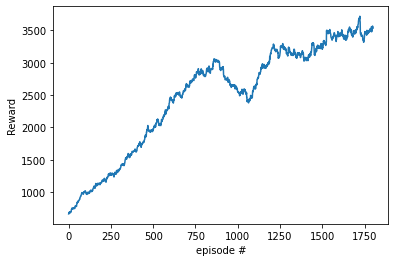

In [ ]:
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg*10)
plt.ylabel("Reward")
plt.xlabel("episode #")
plt.show()